# Метрики

## Imports

In [1]:
!pip install rectools
!pip install pandas
!pip install numba
!pip install numpy
import pandas as pd
import numpy as np
import numba as nb

from tqdm.auto import tqdm
from rectools import Columns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 1.8 MB/s 
     |████████████████████████████████| 310 kB 50.0 MB/s 
     |████████████████████████████████| 1.1 MB 49.4 MB/s 
     |████████████████████████████████| 13.5 MB 25.5 MB/s 
     |████████████████████████████████| 88 kB 8.0 MB/s 
     |████████████████████████████████| 60 kB 7.8 MB/s 
     |████████████████████████████████| 188 kB 73.8 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3411082 sha256=2e9750b93a4d03161ffe55b7a5bd20af378ee8c8d14340b199a3233c9f61b558
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705378 sha256=55746632c4373f7fbabd3ea0df618ecbec6e8c23cd8607141b965df0d41fec07
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3b

In [2]:
np.random.seed(23)

## Homework

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import requests
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'

In [5]:
req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [6]:
import zipfile as zf

files = zf.ZipFile('kion.zip','r')
files.extractall()
files.close()

In [7]:
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [8]:
interactions

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [9]:
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [10]:
def generate_subsample(n_users, top_k):
  users = np.random.choice(interactions['user_id'].unique(), n_users)
  interactions_new = interactions[interactions['user_id'].isin(users)].reset_index(drop=True)
  recs = np.random.choice(interactions_new['item_id'], size=(n_users, top_k))
  return users, interactions_new.drop(['datetime', 'weight', 'watched_pct'], axis=1).values, recs

In [11]:
users_df, target_df, recs_df  = generate_subsample(500, 10)

Naive

In [12]:
def mrr_naive(users, target, recs):
  mrr_sub = []
  for i, user in enumerate(users):
    user_target = target[target[:, 0] == user][:, 1]
    rank = 0.0
    for j, rec in enumerate(recs[i]):
      if rec in user_target:
        rank = 1 / (j + 1)
        break
    mrr_sub.append(rank)
  return sum(mrr_sub) / len(users)

In [13]:
mrr_naive(users_df, target_df, recs_df)

0.06618253968253965

Numba

In [14]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(users, target, recs):
  res = np.zeros(len(users))
  for i in nb.prange(len(users)):
    user = users[i]
    user_target = target[target[:, 0] == user][:, 1]
    rank = 0
    for j, rec in enumerate(recs[i]):
      if rec in user_target:
        rank = 1 / (j + 1)
        break
    res[i] = rank
  return res.mean()

In [15]:
mrr_numba(users_df, target_df, recs_df)

0.06618253968253968

In [16]:
def mrr_pandas(users, target, recs):
  df_recs = pd.DataFrame({
          'user_id': np.repeat(users, recs.shape[1]),
          'item_id': recs.ravel()
  })
  df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
  target['target'] = 1
  df_recs = df_recs.merge(target, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
  df_recs['mrr'] = 0
  df_recs.loc[~df_recs['target'].isna(), 'mrr'] = 1 / (df_recs.loc[~df_recs['target'].isna(), 'rank'])
  mrr = df_recs.groupby('user_id')['mrr'].max().mean()
  return mrr

In [17]:
target_df = pd.DataFrame(target_df, columns=['user_id', 'item_id'])
mrr_pandas(users_df, target_df, recs_df)

0.06618253968253969

In [18]:
from itertools import product

import timeit

users_count = [10, 100, 1000, 10000]
top_k = [10, 50, 100]
n_runs = 5
res = []

for u_count, k in list(product(users_count, top_k)):
  users, target, recs = generate_subsample(u_count, k)
  for algo in [mrr_naive, mrr_numba, mrr_pandas]:
    algo_name =  algo.__name__
    if algo_name == 'mrr_pandas':
      target = pd.DataFrame(target, columns=['user_id', 'item_id'])

    avg_time = timeit.timeit('algo(users, target, recs)', "from __main__ import algo, users, target, recs" , number=n_runs) / n_runs
    print(f'algo: {algo_name}, user_count: {u_count}, k: {k}, avg_time: {avg_time:0.5f} s')

    res.append({
        'top_k': k,
        'users_count': u_count,
        'algo': algo_name,
        'avg_time': avg_time
    })
  print()

res = pd.DataFrame(res)

algo: mrr_naive, user_count: 10, k: 10, avg_time: 0.00042 s
algo: mrr_numba, user_count: 10, k: 10, avg_time: 0.00002 s
algo: mrr_pandas, user_count: 10, k: 10, avg_time: 0.00819 s

algo: mrr_naive, user_count: 10, k: 50, avg_time: 0.00201 s
algo: mrr_numba, user_count: 10, k: 50, avg_time: 0.00002 s
algo: mrr_pandas, user_count: 10, k: 50, avg_time: 0.00831 s

algo: mrr_naive, user_count: 10, k: 100, avg_time: 0.00109 s
algo: mrr_numba, user_count: 10, k: 100, avg_time: 0.00722 s
algo: mrr_pandas, user_count: 10, k: 100, avg_time: 0.01308 s

algo: mrr_naive, user_count: 100, k: 10, avg_time: 0.00618 s
algo: mrr_numba, user_count: 100, k: 10, avg_time: 0.02099 s
algo: mrr_pandas, user_count: 100, k: 10, avg_time: 0.01066 s

algo: mrr_naive, user_count: 100, k: 50, avg_time: 0.02112 s
algo: mrr_numba, user_count: 100, k: 50, avg_time: 0.00891 s
algo: mrr_pandas, user_count: 100, k: 50, avg_time: 0.01705 s

algo: mrr_naive, user_count: 100, k: 100, avg_time: 0.03213 s
algo: mrr_numba, us

In [21]:
res.head()

,top_k,users_count,algo,avg_time
0,10,10,mrr_naive,0.000424
1,10,10,mrr_numba,0.000015
2,10,10,mrr_pandas,0.008187
3,50,10,mrr_naive,0.002006
4,50,10,mrr_numba,0.000018


In [26]:
import seaborn as sns

def plot(need_log=False, y_lim=(0, 0.4)):
  time_col = 'log_time' if need_log else 'avg_time'
  g = sns.FacetGrid(res, col="top_k", hue='algo')
  g.figure.set_size_inches(15, 4)
  g.map(sns.lineplot, "users_count", time_col, marker="o")
  g.set(ylim=y_lim)
  g.add_legend()

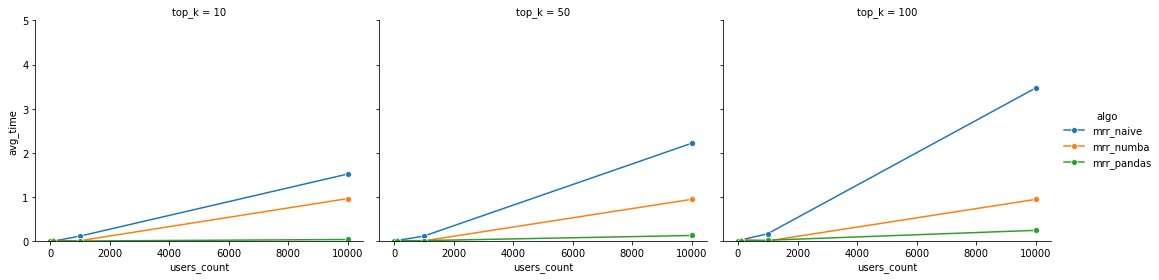

In [29]:
plot(y_lim=(0, 5))